In [14]:
import pandas as pd
import json
import os 
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import patches

In [4]:
ids = []
for file_name in os.listdir('../haystack/irrelevant'):
    if file_name.endswith('.txt'):
        file_id = os.path.splitext(file_name)[0]  # Extract the file name without extension
        ids.append(file_id)
print(ids)

['1', '11', '121', '122', '123', '124', '14', '15', '155', '16', '160', '163', '164', '167', '168', '17', '170', '172', '173', '175', '18', '180', '182', '183', '185', '189', '192', '193', '196', '198', '2', '29', '3', '380', '391', '393', '396', '4', '401', '403', '408', '409', '410', '411', '420', '421', '422', '423', '424', '427', '43', '430', '432', '433', '435', '436', '437', '438', '439', '44', '441', '442', '444', '448', '449', '453', '5', '532', '535', '539', '576', '577', '578', '579', '586', '587', '588', '589', '590', '92', '95', '96']


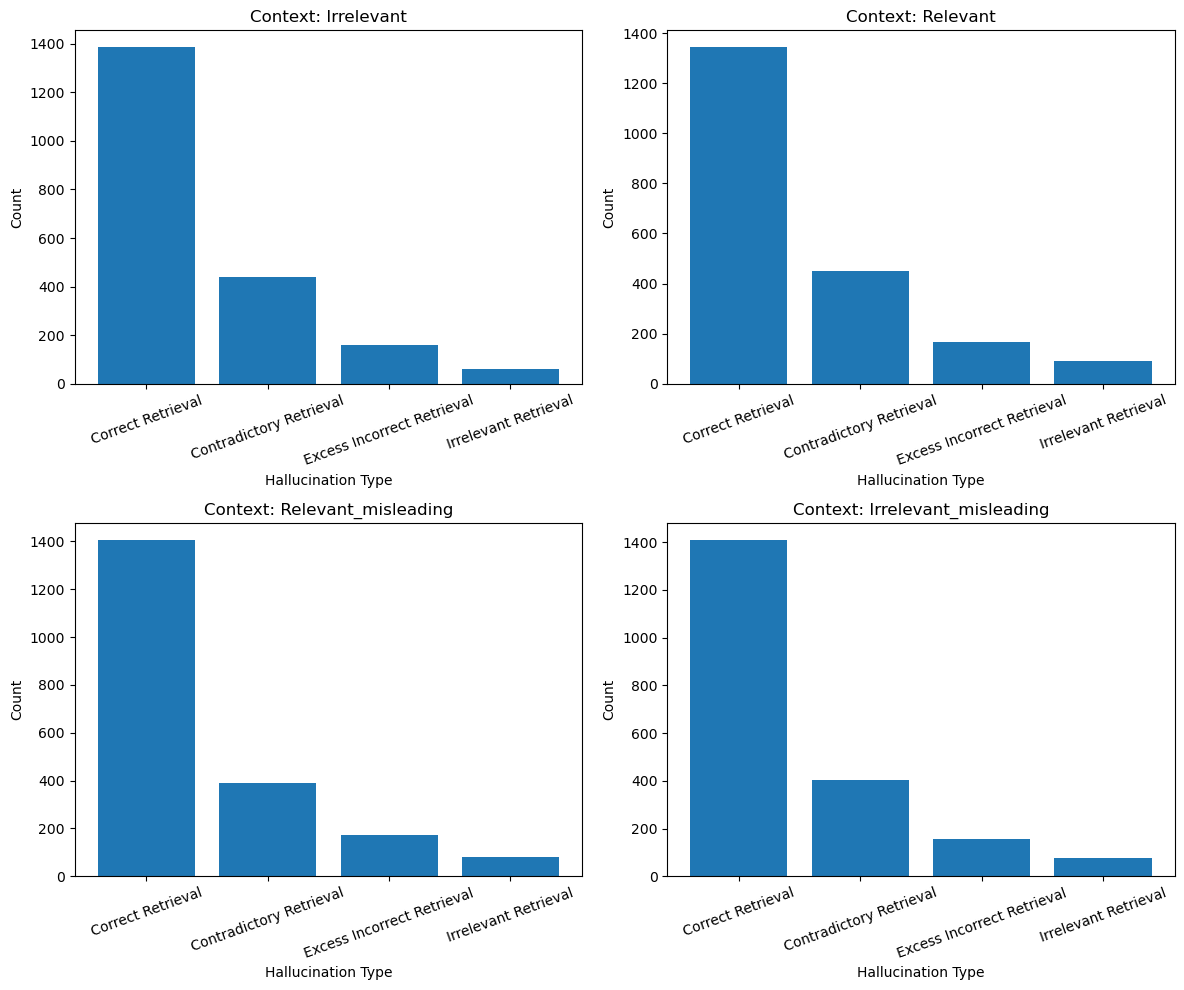

In [21]:
all_rows = []

for id in ids:
    try:
        with open(f"updated_unique_responses/{id}.json", "r") as f:
            data = json.load(f)
            for category, entries in data.items():
                for entry in entries:
                    entry['context_category'] = category
                    entry['id'] = id
                    all_rows.append(entry)

    except FileNotFoundError:
            pass

df = pd.DataFrame(all_rows)
df['scores'] = df['hallucination_type'].apply(
    lambda x: 100.0 if x == 'Correct Retrieval' else 0.0
)

# row: depth, col: context length
depth_percentages_set = set(df['depth_percent'])
context_length_set = set(df['context_length'])

score_matrix = pd.DataFrame(0, index=sorted(list(depth_percentages_set)), columns=sorted(list(context_length_set)))

score_mean_matrices = {
    "irrelevant": score_matrix.copy(),
    "relevant": score_matrix.copy(),
    "relevant_misleading": score_matrix.copy(),
    "irrelevant_misleading": score_matrix.copy()
}

score_var_matrices = {
    "irrelevant": score_matrix.copy(),
    "relevant": score_matrix.copy(),
    "relevant_misleading": score_matrix.copy(),
    "irrelevant_misleading": score_matrix.copy()
}

bar_charts = {
    "irrelevant": None,
    "relevant": None,
    "relevant_misleading": None,
    "irrelevant_misleading": None
}
     
for context_key in score_mean_matrices.keys():
    bar_chart_df = df[df['context_category'] == context_key]
    hallucination_counts = bar_chart_df['hallucination_type'].value_counts().to_dict()
    bar_charts[context_key] = defaultdict(lambda: 0, hallucination_counts)
    
    for depth in depth_percentages_set:
        for context_length in context_length_set:
            filtered_df = df[(df['depth_percent'] == depth) & (df['context_length'] == context_length) & (df['context_category'] == context_key)]

            if not filtered_df.empty:
                avg_val = filtered_df['scores'].mean()
                # using population variance
                var_val = filtered_df['scores'].var(ddof=0)
                score_mean_matrices[context_key].loc[depth, context_length] = avg_val
                score_var_matrices[context_key].loc[depth, context_length] = var_val

# Assuming bar_charts has exactly 4 items
fig, axes = plt.subplots(2, 2, figsize=(12, 10))  # 2 rows x 2 cols of subplots
axes = axes.flatten()  # Flatten to make it easier to loop through

for idx, (context_key, context_values) in enumerate(bar_charts.items()):
    ax = axes[idx]
    x_axis = ["Correct Retrieval", "Contradictory Retrieval", "Excess Incorrect Retrieval", "Irrelevant Retrieval"]
    ax.bar(x_axis, [context_values[key] for key in x_axis])
    ax.set_xlabel("Hallucination Type")
    ax.set_ylabel("Count")
    ax.set_title("Context: " + context_key.capitalize())
    ax.tick_params(axis='x', rotation=20)

plt.tight_layout()
plt.show()


In [ ]:
bar_charts.keys()

dict_keys(['irrelevant', 'relevant', 'relevant_misleading', 'irrelevant_misleading'])

In [31]:

dfs = [(k, pd.DataFrame(v)) for k, v in score_mean_matrices.items()]
pivot_tables = []
for k, df in dfs:
    print(df)
    df = df.reset_index().melt(id_vars='index', var_name='context_length', value_name='score')
    df = df.rename(columns={'index': 'depth_percentage'})  
    print(df)
    pivot_table = pd.pivot_table(df, values='score', index=['depth_percentage', 'context_length'], aggfunc='mean').reset_index()
    pivot_table = pivot_table.pivot(index="depth_percentage", columns="context_length", values="score")
    pivot_tables.append((k, pivot_table))


            0          1250       2500       3750       5000
0.0    80.487805  35.365854  37.804878  39.024390  36.585366
25.0   76.829268  70.731707  70.731707  67.073171  62.195122
50.0   79.268293  65.853659  71.951220  70.731707  71.951220
75.0   81.707317  67.073171  79.268293  70.731707  68.292683
100.0  78.048780  73.170732  79.268293  78.048780  78.048780
    depth_percentage context_length      score
0                0.0              0  80.487805
1               25.0              0  76.829268
2               50.0              0  79.268293
3               75.0              0  81.707317
4              100.0              0  78.048780
5                0.0           1250  35.365854
6               25.0           1250  70.731707
7               50.0           1250  65.853659
8               75.0           1250  67.073171
9              100.0           1250  73.170732
10               0.0           2500  37.804878
11              25.0           2500  70.731707
12              50.0   

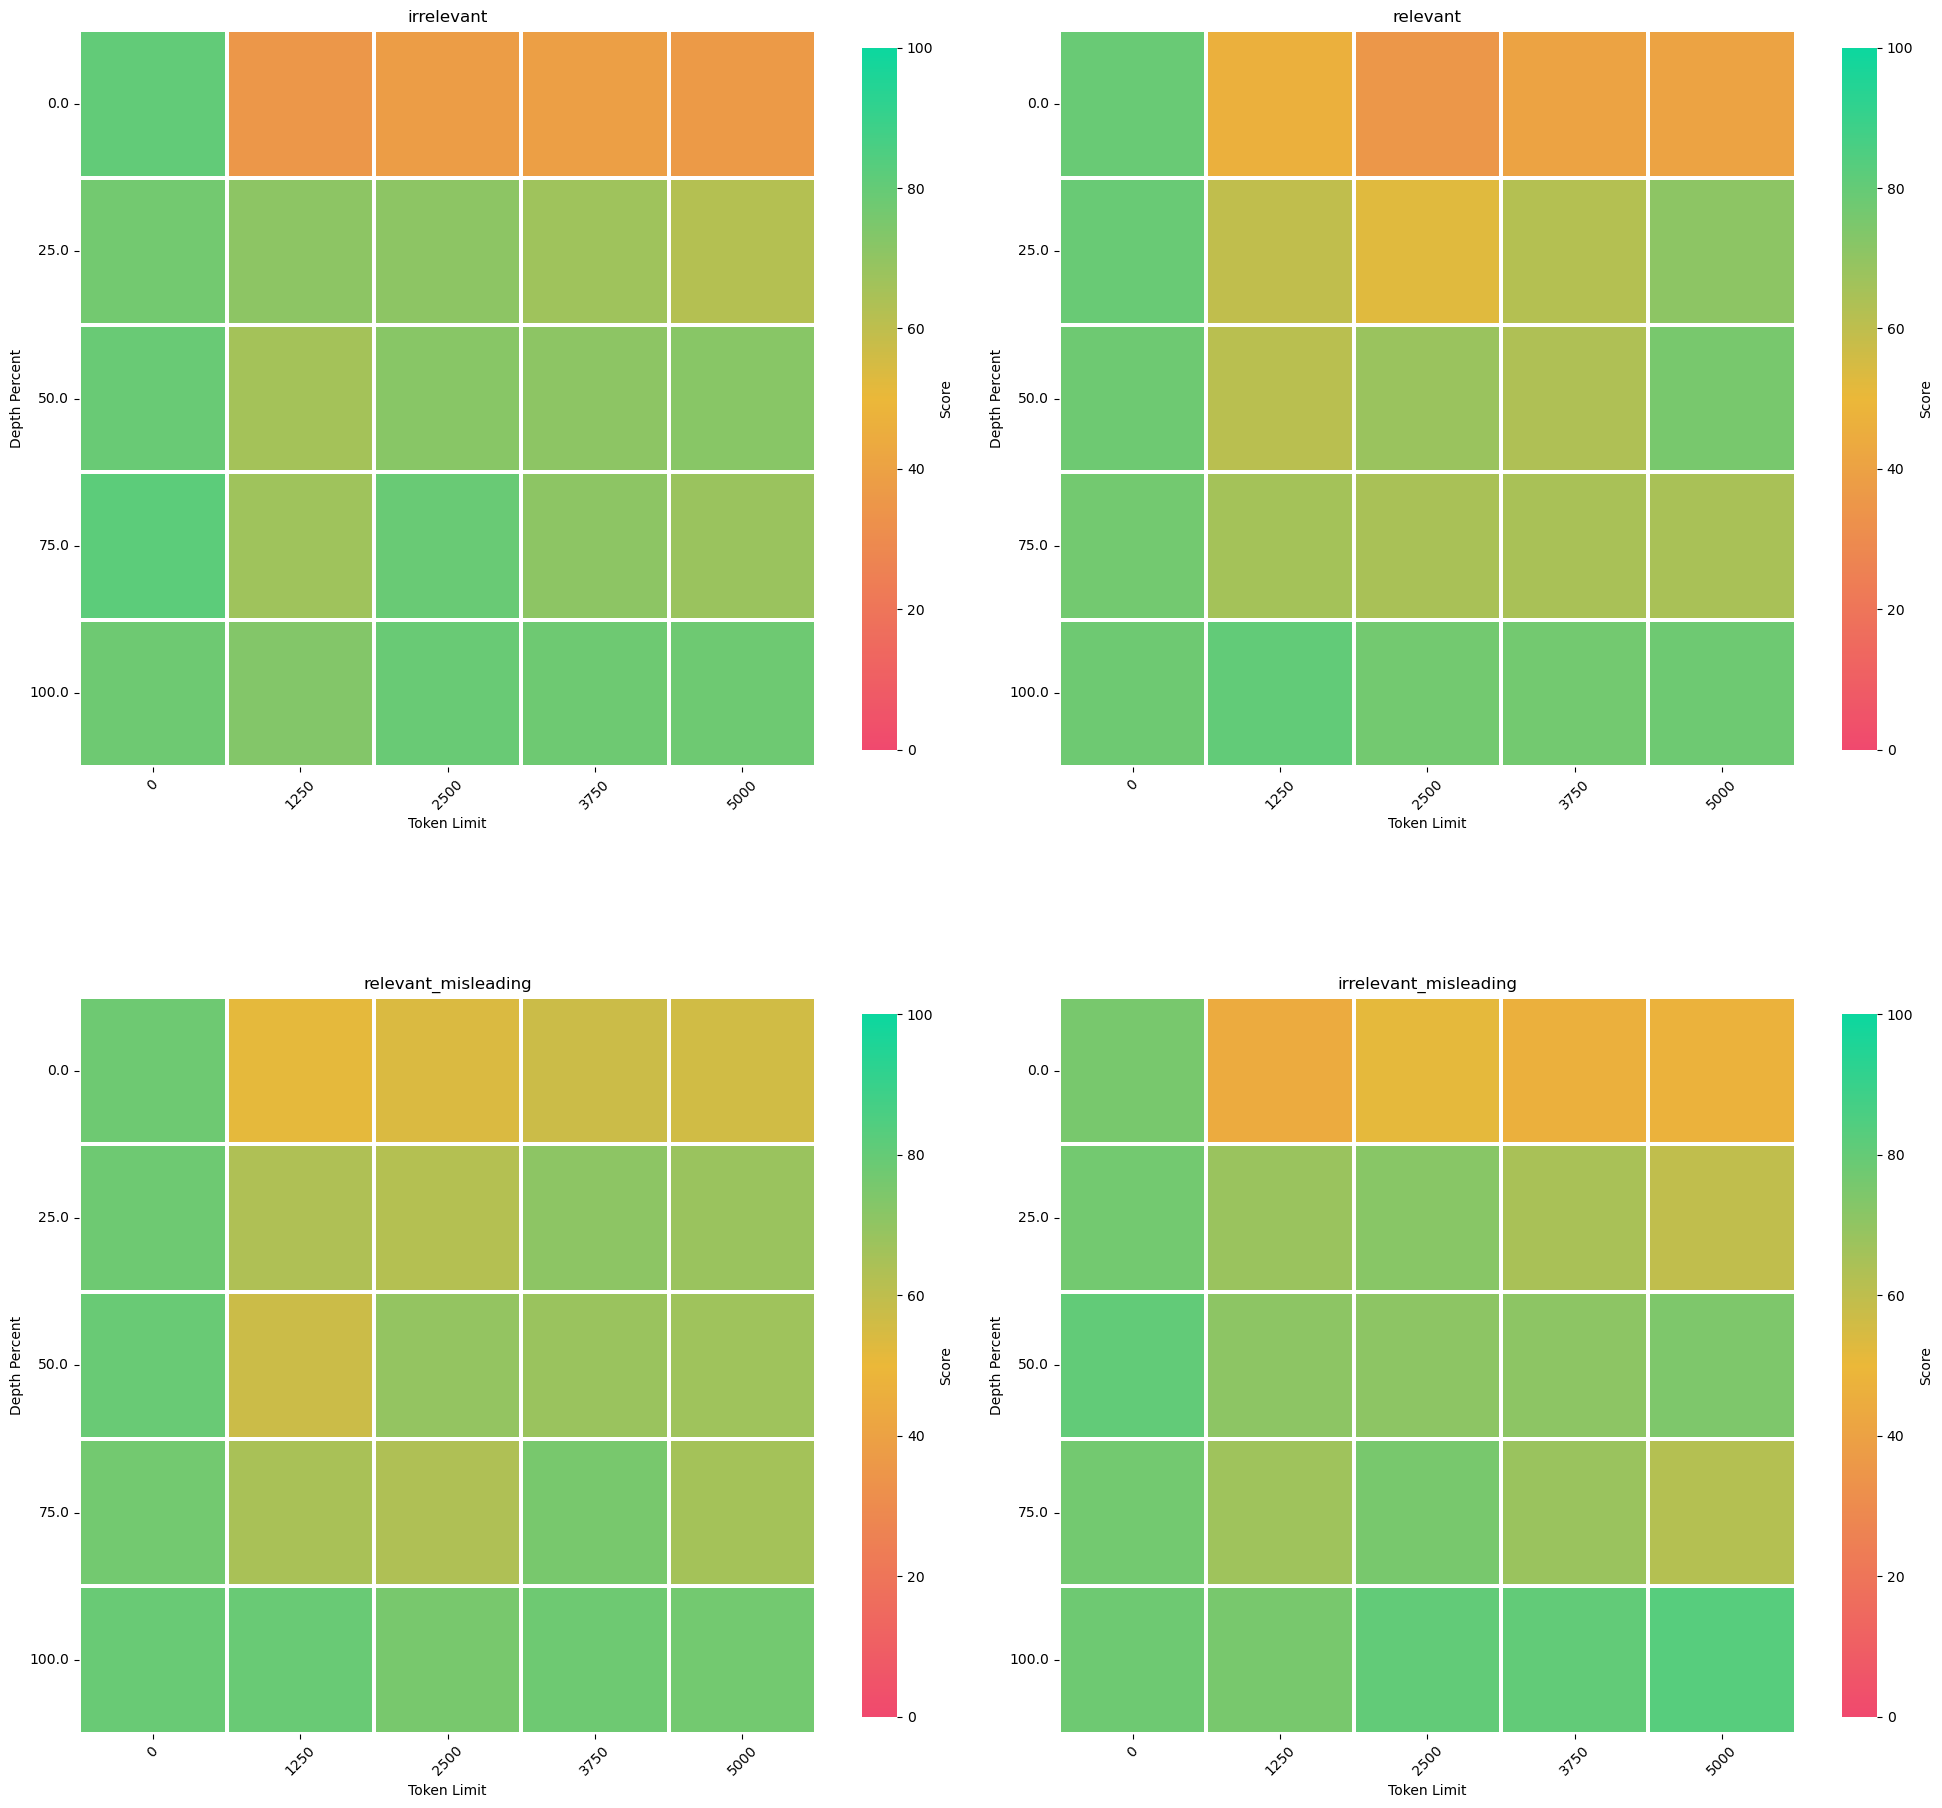

In [30]:
plt.figure(figsize=(20, 20))

for i, (title, data) in enumerate(pivot_tables, 1):
        
    plt.subplot(2, 2, i)
    cmap = LinearSegmentedColormap.from_list("custom_cmap", ["#F0496E", "#EBB839", "#0CD79F"])
    sns.heatmap(
        data,
        cmap=cmap,
        vmin=0, 
        vmax=100,
        square=True,
        linewidths=1.5,             
        linecolor='white',
        cbar_kws={'label': 'Score', 'shrink': 0.7})
        
    # Add a custom legend
    # legend_labels = ['No Hallucination', 'Hallucination']
    # colors = ['#0CD79F', '#F0496E']

    # Create legend patches
    # patches_list = [patches.Patch(color=color, label=label) for color, label in zip(colors, legend_labels)]
    # plt.legend(handles=patches_list, loc='upper left')
    plt.title(title)
    plt.xlabel('Token Limit')
    plt.ylabel('Depth Percent')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    
    
plt.tight_layout()
plt.show()
